## Feature Engineering

###  Install TA-Lib

In [1]:
#!pip install TA-Lib
# If installation fails, follow platform-specific guide: https://mrjbq7.github.io/ta-lib/install.html

### Import Libraries

In [2]:
import talib as ta
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set_theme(style="whitegrid", rc={"axes.facecolor": "#f0f0f0"})

###  Load Cleaned Data

In [3]:
# Load the cleaned QQQ data
df = pd.read_csv("QQQ_Clean_Data.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)  # Set Date as index for time-series operations
print("Initial Data:")
display(df.head())

Initial Data:


,Open,High,Low,Close,Volume,10Y_Yield,SOXX_Close,VIX
Date,,,,,,,,
2010-01-04,40.407333,40.546879,40.355002,40.485825,62822800,3.85,14.099307,20.040001
2010-01-05,40.459661,40.555599,40.259064,40.485825,62935600,3.77,14.076675,19.350000
2010-01-06,40.468364,40.599187,40.180549,40.241600,96033000,3.85,14.034232,19.160000
2010-01-07,40.302656,40.354987,40.049728,40.267769,77094100,3.85,13.923882,19.059999
2010-01-08,40.180556,40.599194,40.058453,40.599194,88886600,3.83,14.133264,18.129999


### Engineer Technical Features

In [4]:
# 1. Momentum Indicators
df["RSI_14"] = ta.RSI(df["Close"], timeperiod=14)  # Relative Strength Index

# 2. Trend Indicators
df["MACD"], df["MACD_Signal"], _ = ta.MACD(df["Close"], fastperiod=12, slowperiod=26, signalperiod=9)

# 3. Volatility Indicators
df["ATR_14"] = ta.ATR(df["High"], df["Low"], df["Close"], timeperiod=14)  # Average True Range
df["Bollinger_Upper"], df["Bollinger_Mid"], df["Bollinger_Lower"] = ta.BBANDS(df["Close"], timeperiod=20)

# 4. Volume-Adjusted Features
df["Volume_MA_10"] = df["Volume"].rolling(10).mean()  # 10-day volume moving average

### Add Macroeconomic & Sector Features

In [5]:
# 1. Lagged Treasury Yield Changes
df["10Y_Yield_Change"] = df["10Y_Yield"].pct_change(periods=5)  # 5-day yield momentum

# 2. SOXX Relative Strength (QQQ vs SOXX)
df["SOXX_Ratio"] = df["Close"] / df["SOXX_Close"]  # Tech vs semis relative performance

# 3. VIX Regime Binning
df["VIX_Regime"] = pd.cut(df["VIX"], bins=[0, 15, 25, 50], labels=["Low", "Medium", "High"])
df = pd.get_dummies(df, columns=["VIX_Regime"], prefix="VIX")  # One-hot encode

### Create Lagged Features

In [6]:
# Lagged returns (avoid look-ahead bias)
for lag in [1, 3, 5]:
    df[f"Return_Lag_{lag}"] = df["Close"].pct_change(lag)

# Rolling volatility
df["Volatility_21D"] = df["Close"].pct_change().rolling(21).std() * np.sqrt(252)  # Annualized

### Handle Missing Data

In [7]:
# Drop rows with NaN (from rolling windows)
df.dropna(inplace=True)

# Final check
print("\nMissing Values After Cleaning:")
print(df.isnull().sum())


Missing Values After Cleaning:
Open                0
High                0
Low                 0
Close               0
Volume              0
10Y_Yield           0
SOXX_Close          0
VIX                 0
RSI_14              0
MACD                0
MACD_Signal         0
ATR_14              0
Bollinger_Upper     0
Bollinger_Mid       0
Bollinger_Lower     0
Volume_MA_10        0
10Y_Yield_Change    0
SOXX_Ratio          0
VIX_Low             0
VIX_Medium          0
VIX_High            0
Return_Lag_1        0
Return_Lag_3        0
Return_Lag_5        0
Volatility_21D      0
dtype: int64


### Visualize Key Features

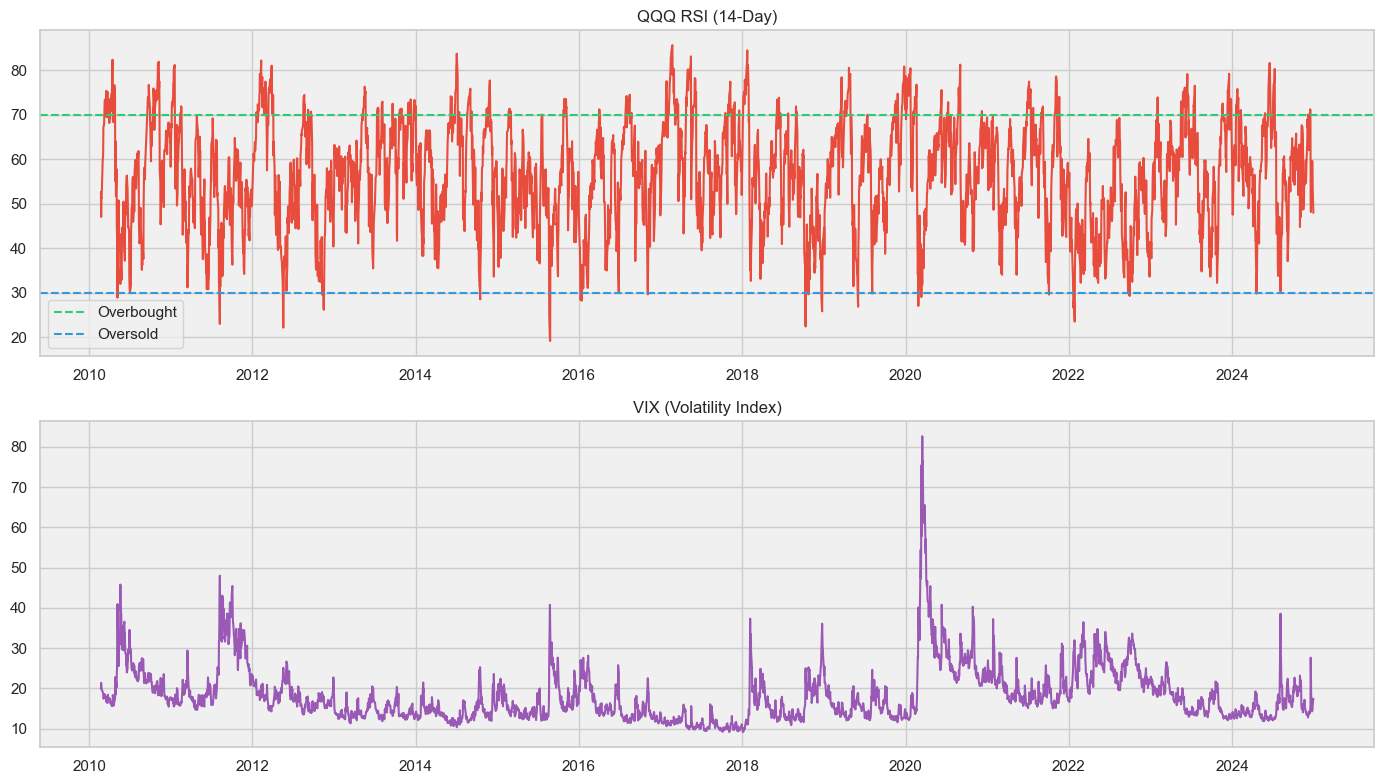

In [8]:
# Plot RSI and VIX regimes
plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
plt.plot(df["RSI_14"], color="#e74c3c", linewidth=1.5)
plt.axhline(70, color="#2ecc71", linestyle="--", label="Overbought")
plt.axhline(30, color="#3498db", linestyle="--", label="Oversold")
plt.title("QQQ RSI (14-Day)", fontsize=12)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df["VIX"], color="#9b59b6", linewidth=1.5)
plt.title("VIX (Volatility Index)", fontsize=12)
plt.tight_layout()
plt.show()

### Save Engineered Data

In [9]:
df.to_csv("QQQ_Engineered_Data.csv")
print("\nData saved to 'QQQ_Engineered_Data.csv'")


Data saved to 'QQQ_Engineered_Data.csv'
